In [47]:
### Import libraries

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

2.13.0


In [48]:


#Array che contiene le categorie di ogni time series. Dim 48000x1
categories = np.load("/kaggle/input/challenge-2-data/categories.npy")
#Array che contiene i valori delle time series. Dim 48000x2776
training_data = np.load("/kaggle/input/challenge-2-data/training_data.npy")
#Array che contiene gli indici che descrivono gli estremi degli intervalli validi delle time series. Dim 48000x2
valid_periods = np.load("/kaggle/input/challenge-2-data/valid_periods.npy")

categories.shape, training_data.shape, valid_periods.shape


((48000,), (48000, 2776), (48000, 2))

In [49]:
def clean_data(training_data, garbage_threshold = 210):
    cleaned_data = []
    cleaned_categories = []
    cleaned_valid_periods = []
    for i in range(training_data.shape[0]):
        if valid_periods[i][1] - valid_periods[i][0] >= garbage_threshold:
            cleaned_data.append(training_data[i])
            cleaned_categories.append(categories[i])
            cleaned_valid_periods.append(valid_periods[i])
    return np.array(cleaned_data), np.array(cleaned_categories), np.array(cleaned_valid_periods)

In [50]:
cleaned_data, cleaned_categories, cleaned_valid_periods = clean_data(training_data)

cleaned_categories.shape, cleaned_data.shape, cleaned_valid_periods.shape

((21936,), (21936, 2776), (21936, 2))

In [51]:
def split_for_categories(training_data, categories):
    all_samples_list = []
    for i in np.unique(categories):
        mask = np.where(categories == i, True, False)

        samples_for_category = training_data[mask]
        all_samples_list.append(samples_for_category)
    return np.array(all_samples_list[0]), np.array(all_samples_list[1]), np.array(all_samples_list[2]), np.array(all_samples_list[3]), np.array(all_samples_list[4]), np.array(all_samples_list[5])

In [52]:
data_A, data_B, data_C, data_D, data_E, data_F = split_for_categories(cleaned_data, cleaned_categories)

data_A.shape, data_B.shape, data_C.shape, data_D.shape, data_E.shape, data_F.shape

((3837, 2776),
 (3420, 2776),
 (4917, 2776),
 (5509, 2776),
 (4154, 2776),
 (99, 2776))

In [53]:
def train_test_split(data, train_ratio = 0.8):
    data = data
    
    rows_to_select = int(len(data) * train_ratio)
    training_set = data[:rows_to_select, :]
    test_set = data[rows_to_select:, :]
    
    return training_set, test_set

In [54]:
training_set_A, test_set_A = train_test_split(data_A, train_ratio = 0.8)
training_set_B, test_set_B = train_test_split(data_B, train_ratio = 0.8)
training_set_C, test_set_C = train_test_split(data_C, train_ratio = 0.8)
training_set_D, test_set_D = train_test_split(data_D, train_ratio = 0.8)
training_set_E, test_set_E = train_test_split(data_E, train_ratio = 0.8)
training_set_F, test_set_F = train_test_split(data_F, train_ratio = 0.8)

In [55]:
trainings = [training_set_A,training_set_B,training_set_C,training_set_D,training_set_E,training_set_F]
tests = [test_set_A,test_set_B,test_set_C,test_set_D,test_set_E,test_set_F]

In [56]:
telescope = 9
def build_sequences(df, window=200, stride=20, telescope=telescope):
    
    
    
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()
    padding_check = df.size%window

    #print(temp_df.size)

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - df.size%window
        padding = np.zeros((padding_len), dtype='float32')
        temp_df = np.concatenate((padding,df))
        assert temp_df.size % window == 0

    #print(temp_df.size)
    for idx in np.arange(0,temp_df.size-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_df[idx+window:idx+window+telescope])

    return np.vstack(dataset), np.vstack(labels)

In [57]:
#data is a pandas series containing 48000 lists (either training, validation or test)
def THE_SEQUENCER(data):
    dataset = []
    labels = []
    for i in range(data.shape[0]):
        time_series = data[i][cleaned_valid_periods[i][0]:cleaned_valid_periods[i][1]]
        dset, labs = build_sequences(time_series)
        if len(dset) == 0:
            continue
        dataset.append(dset)
        labels.append(labs)

    return dataset, labels

In [58]:
training_sets = []
training_labels = []

testing_sets = []
testing_labels = []

for i in range(len(trainings)):
    
    train, train_labels = THE_SEQUENCER(trainings[i])
    training_sets.append(train)
    training_labels.append(train_labels)
    
    test, test_labels = THE_SEQUENCER(tests[i])
    testing_sets.append(test)
    testing_labels.append(test_labels)


Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 batch_normalization_2 (Bat  (None, 200, 1)            4         
 chNormalization)                                                
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)          

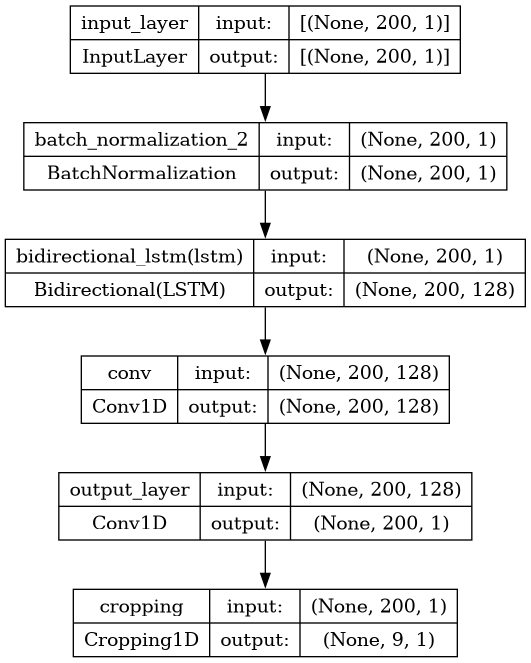

In [59]:
### Build the model


batch_size = 64
epochs = 200

input_shape = (200,1)
output_shape = (telescope,1)


def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.BatchNormalization()(input_layer)

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [60]:
models = []

target_labels = ['A']

for _ in target_labels:
    models.append(build_CONV_LSTM_model(input_shape, output_shape))

In [61]:
from tqdm import tqdm

histories = []

for j,model in enumerate(models): 
    idx = np.argmax(np.unique(categories) == target_labels[j])
    print(idx)
    train_sequences = training_sets[idx]
    train_labels = training_labels[idx]
    for i in tqdm(range(len(train_sequences))):

      histories.append(model.fit(
          x = train_sequences[i],
          y = train_labels[i],
          batch_size = batch_size, 
          epochs = 200,
          verbose = 0,
          validation_split=.1,
          callbacks = [
              tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
              tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
          ]
      ).history)

0


100%|██████████| 6/6 [00:22<00:00,  3.72s/it]


In [62]:
[model.save(f'model_{target_labels[i]}') for i,model in enumerate(models)]

[None]

In [63]:
!zip -r file.zip /kaggle/working

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/model.png (deflated 11%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
updating: kaggle/working/first_trial 1/ (stored 0%)
updating: kaggle/working/first_trial 1/variables/ (stored 0%)
updating: kaggle/working/first_trial 1/variables/variables.index (deflated 65%)
updating: kaggle/working/first_trial 1/variables/variables.data-00000-of-00001 (deflated 7%)
updating: kaggle/working/first_trial 1/fingerprint.pb (stored 0%)
updating: kaggle/working/first_trial 1/keras_metadata.pb (deflated 90%)
updating: kaggle/working/first_trial 1/saved_model.pb (deflated 90%)
updating: kaggle/working/first_trial 1/assets/ (stored 0%)
updating: kaggle/working/model A/ (stored 0%)
updating: kaggle/working/model A/variables/ (stored 0%)
updating: kaggle/working/model A/variables/variables.index (deflated 65%)
updating: kaggle/working/model A/variables/variables.data-00000-of-00001 (deflated 7%)
updating: kaggle/working/model A/finger

In [92]:
def predictions(test_sequences,test_labels,model):
    X_test = []
    y_test = []
    for i in range(len(test_sequences)):
        for j in range(test_sequences[i].shape[0]):
            X_test.append(test_sequences[i][j])
            y_test.append(test_labels[i][j])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    predictions = model.predict(X_test, verbose=0)

    # Print the shape of the predictions
    # print(f"Predictions shape: {predictions.shape}")

    # Calculate and print Mean Squared Error (MSE)
    mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
    mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
    print(f"MAE: {'%.5f' % mean_absolute_error} | MSE: {'%.5f' % mean_squared_error}")

In [93]:
for i,l in enumerate(target_labels):
    print('Test Category: ' + l)
    idx = np.argmax(np.unique(categories) == l)
    predictions(testing_sets[idx],testing_labels[idx],models[i])
    print()

Test Category: A
MAE: 0.30022 | MSE: 0.14337



In [94]:
m = tfk.models.load_model('model_A')
predictions(testing_sets[0],testing_labels[0],m)

MAE: 0.30022 | MSE: 0.14337
